<a href="https://colab.research.google.com/github/haedal-uni/analysis/blob/main/LSTM%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%A3%BC%EA%B0%80_%EC%98%88%EC%B8%A1_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LSTM을 활용한 주가 예측 모델

https://colab.research.google.com/github/teddylee777/machine-learning/blob/master/04-TensorFlow2.0/01-%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90-%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1/02-LSTM-stock-forecasting-with-LSTM-financedatareader.ipynb#scrollTo=WvpWt3-598VR

위 코드를 보고 작성


In [61]:
import warnings
import matplotlib
import sys
import numpy as np
import os
import pandas as pd

warnings.filterwarnings(action='ignore')

if 'google.colab' in sys.modules:
    !echo 'debconf debconf/frontend select Noninteractive' | debconf-set-selections
    # 나눔 폰트를 설치
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

matplotlib.rcParams['font.family'] = 'NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

import pandas as pd
df = pd.read_csv('미국 철강 코일 선물 과거 데이터.csv', parse_dates=['날짜'], index_col="날짜", thousands=",") # 구분자 제거
df = df.sort_index()
df.head()

,종가,시가,고가,저가,거래량,변동 %
날짜,,,,,,
2015-01-02,605.0,605.0,605.0,605.0,NaN,0.00%
2015-01-05,605.0,605.0,605.0,605.0,NaN,0.00%
2015-01-06,605.0,605.0,605.0,605.0,NaN,0.00%
2015-01-07,597.0,597.0,597.0,597.0,0.05K,-1.32%
2015-01-08,597.0,597.0,597.0,597.0,NaN,0.00%


In [62]:
df.tail(5)

,종가,시가,고가,저가,거래량,변동 %
날짜,,,,,,
2025-04-01,895.0,894.0,895.0,894.0,0.07K,0.56%
2025-04-02,915.0,897.0,920.0,897.0,0.11K,2.23%
2025-04-03,913.0,913.0,914.0,913.0,0.01K,-0.22%
2025-04-04,932.0,913.0,945.0,905.0,0.14K,2.08%
2025-04-07,930.0,930.0,935.0,925.0,0.01K,-0.21%


In [63]:
# 거래량과 변동도 수치로 변경
df['거래량'] = df['거래량'].apply(lambda x: float(x.replace('K', '')) * 1000 if isinstance(x, str) and 'K' in x else float(x))
df['변동 %'] = df['변동 %'].apply(lambda x: float(x.replace('%', '')) / 100 if isinstance(x, str) else x)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2598 entries, 2015-01-02 to 2025-04-07
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   종가      2598 non-null   float64
 1   시가      2598 non-null   float64
 2   고가      2598 non-null   float64
 3   저가      2598 non-null   float64
 4   거래량     1679 non-null   float64
 5   변동 %    2598 non-null   float64
dtypes: float64(6)
memory usage: 142.1 KB


Text(0, 0.5, 'price')

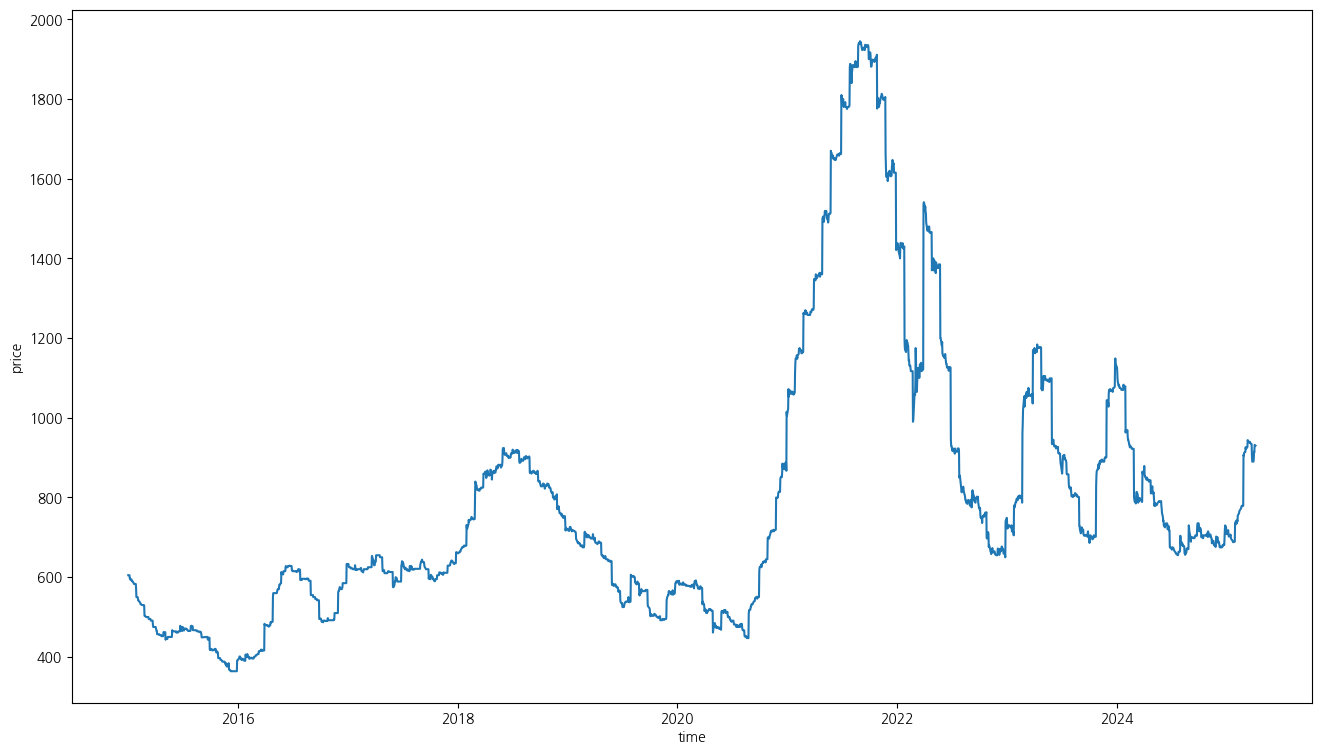

In [65]:
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 9))
sns.lineplot(y=df['종가'], x=df.index)
plt.xlabel('time')
plt.ylabel('price')

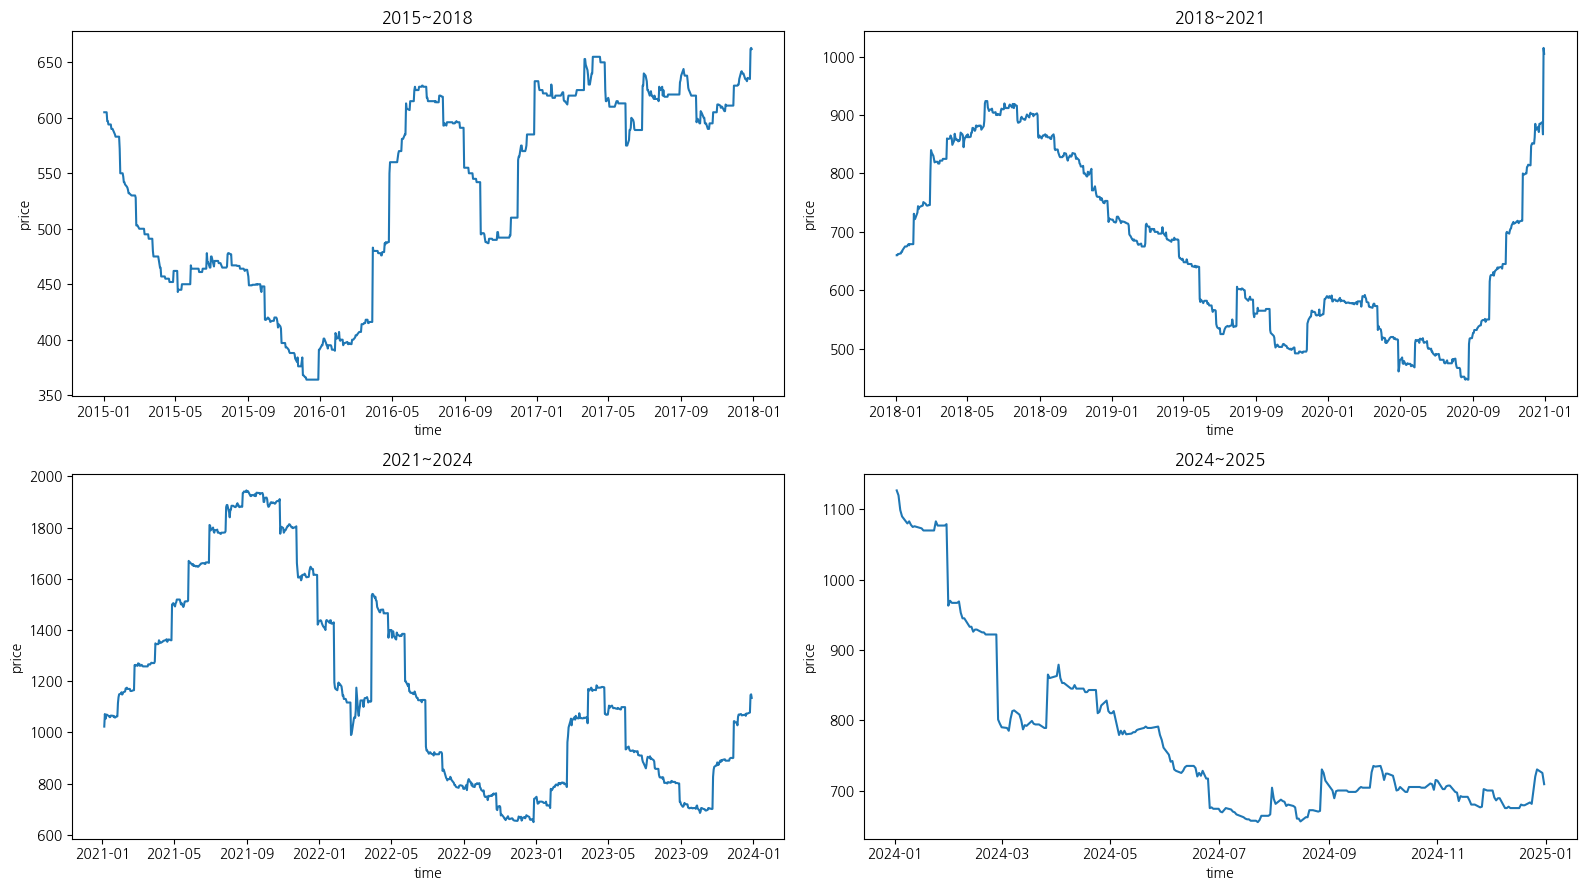

In [66]:
df.index = pd.to_datetime(df.index)

time_steps = [['2015', '2018'],
              ['2018', '2021'],
              ['2021', '2024'],
              ['2024', '2025']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    data = df.loc[(df.index > time_steps[i][0]) & (df.index < time_steps[i][1])]
    sns.lineplot(y=data['종가'], x=data.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

In [67]:
# 데이터 전처리
## 주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 정규화(Normalization)를 해주도록 한다.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의한다.
scale_cols = ['종가', '시가', '고가', '저가', '거래량']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])
scaled

array([[0.15243517, 0.15243517, 0.15243517, 0.15262825,        nan],
       [0.15243517, 0.15243517, 0.15243517, 0.15262825,        nan],
       [0.15243517, 0.15243517, 0.15243517, 0.15262825,        nan],
       ...,
       [0.34724858, 0.34724858, 0.34788109, 0.34768841, 0.00787402],
       [0.35926629, 0.34724858, 0.36748893, 0.34262191, 0.11023622],
       [0.35800127, 0.35800127, 0.36116382, 0.35528816, 0.00787402]])

In [68]:
df = pd.DataFrame(scaled, columns=scale_cols)

# train, test 분할
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('종가', axis=1), df['종가'], test_size=0.2, random_state=0, shuffle=False)
x_train.shape, y_train.shape

((2078, 4), (2078,))

In [69]:
x_test.shape, y_test.shape

((520, 4), (520,))

In [70]:
x_train

,시가,고가,저가,거래량
0,0.152435,0.152435,0.152628,NaN
1,0.152435,0.152435,0.152628,NaN
2,0.152435,0.152435,0.152628,NaN
3,0.147375,0.147375,0.147562,0.039370
4,0.147375,0.147375,0.147562,NaN
...,...,...,...,...
2073,0.440228,0.444023,0.439519,0.078740
2074,0.440228,0.440860,0.437619,0.031496
2075,0.437698,0.437698,0.438252,NaN
2076,0.447818,0.447818,0.437619,0.015748


In [71]:
# TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)


WINDOW_SIZE=20
BATCH_SIZE=32

# Hyperparameter를 정의
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋이다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [72]:
# 모델

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용한다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춘다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성한다.
filename = os.path.join('tmp', 'checkpointer.weights.h5')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

history = model.fit(train_data,
                    validation_data=(test_data),
                    epochs=50,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
     59/Unknown 4s 18ms/step - loss: 0.0057 - mse: 0.0114
Epoch 1: val_loss improved from inf to 0.00044, saving model to tmp/checkpointer.weights.h5
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0055 - mse: 0.0110 - val_loss: 4.3731e-04 - val_mse: 8.7463e-04
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1196e-04 - mse: 4.2392e-04
Epoch 2: val_loss improved from 0.00044 to 0.00035, saving model to tmp/checkpointer.weights.h5
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.1447e-04 - mse: 4.2894e-04 - val_loss: 3.5058e-04 - val_mse: 7.0116e-04
Epoch 3/50
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8397e-04 - mse: 3.6794e-04
Epoch 3: val_loss improved from 0.00035 to 0.00033, saving model to tmp/checkpointer.weights.h5
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.8834e-04 - mse: 3.7668e-04 - val_loss: 3.3272e-04 - val_mse: 6.6544e-04
Epoch 4/50
59/65 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5193e-04 - mse: 3.0386e-04
Epoch 4: val_loss did not

In [73]:
# 저장한 ModelCheckpoint 를 로드
model.load_weights(filename)

In [74]:
# test_data를 활용하여 예측을 진행
pred = model.predict(test_data)
pred.shape

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


(500, 1)

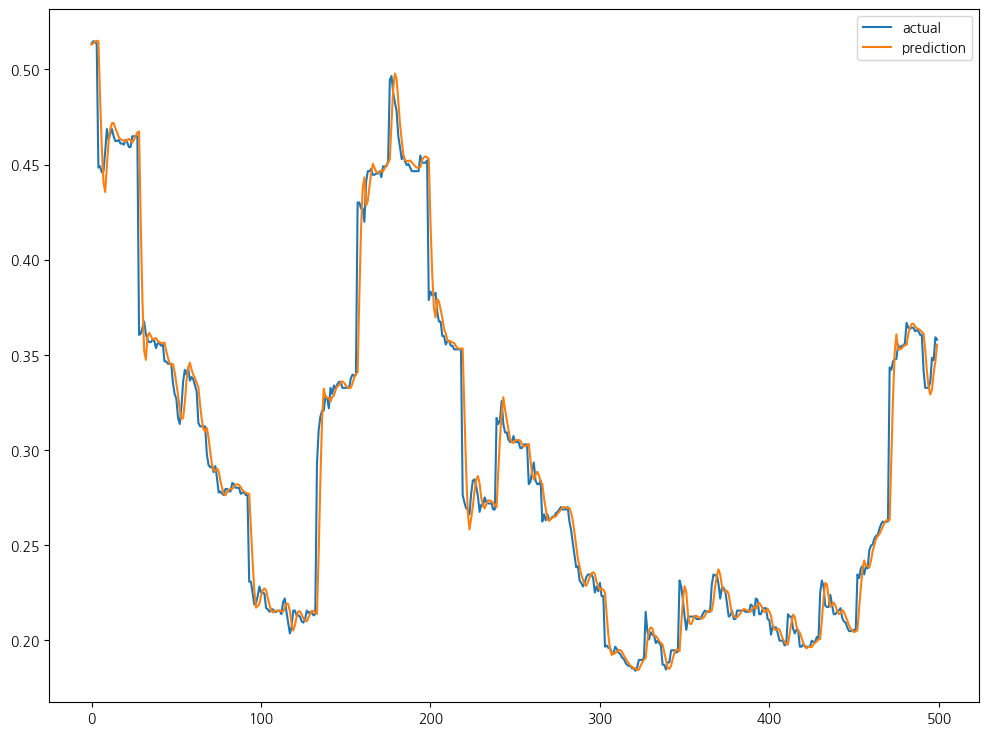

In [75]:
'''
예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 [20:]으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 앞의 20일은 예측하지 않는다.

따라서, 20번 째 index와 비교하면 더욱 정확하다.
'''
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()